In [1]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [1]:
from data_preprocessing.data_preprocessing_1 import create_segmentation_datasets

In [2]:
image_dir = '../../training_data/segmentation_dataset/images'
mask_dir = '../../training_data/segmentation_dataset/masks'

dataset_train, dataset_val, dataset_test = create_segmentation_datasets(image_dir=image_dir, mask_dir=mask_dir, batch_size=24, val_split=0.2, test_split=0.1)

for imgs, masks in dataset_train.take(1):
    print('Train batch images:', imgs.shape, 'masks:', masks.shape)
for imgs, masks in dataset_val.take(1):
    print('Val batch images:', imgs.shape, 'masks:', masks.shape)
for imgs, masks in dataset_test.take(1):
    print('Test batch images:', imgs.shape, 'masks:', masks.shape)

Training samples: 4634, validation samples: 1324, test samples: 662
Train batch images: (24, 384, 508, 3) masks: (24, 384, 508, 1)
Val batch images: (24, 384, 508, 3) masks: (24, 384, 508, 1)
Test batch images: (24, 384, 508, 3) masks: (24, 384, 508, 1)


In [3]:
# import tensorflow as tf
# import numpy as np
# from collections import Counter

# def count_classes_in_dataset(dataset):
#     total_counter = Counter()

#     for batch in dataset:
#         images, masks = batch
#         flat_masks = tf.reshape(masks, [-1])
#         result = tf.unique_with_counts(flat_masks)
#         unique_vals = result.y
#         counts = result.count

#         for val, count in zip(unique_vals.numpy(), counts.numpy()):
#             total_counter[int(val)] += int(count)

#     print("\n Dataset 中的类别总分布：")
#     for cls in sorted(total_counter.keys()):
#         print(f"类 {cls}: {total_counter[cls]} 像素")

#     return total_counter

# # 示例调用
# count_classes_in_dataset(dataset_train)

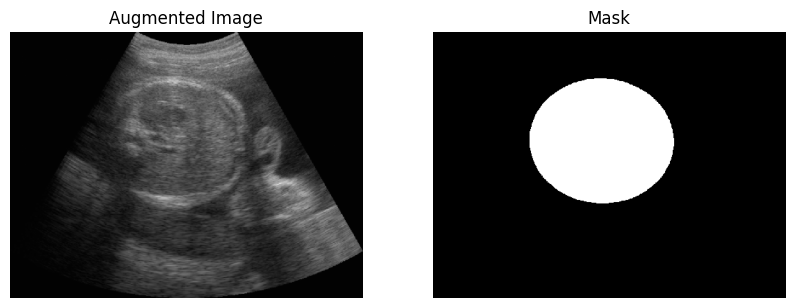

In [4]:
import matplotlib.pyplot as plt
import numpy as np

for img_batch, mask_batch in dataset_train.take(1):
    img = img_batch[0].numpy()
    mask = mask_batch[0].numpy()

    # 1. 将图像从 [-1, 1] 转回 [0, 1] 浮点图像
    img_display = (img + 1.0) / 2.0
    img_display = np.clip(img_display, 0.0, 1.0)

    # 2. 将 mask squeeze，转换为 uint8，用于灰度显示
    mask_display = np.squeeze(mask).astype(np.uint8)

    # 可视化
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_display, cmap='gray', vmin=0.0, vmax=1.0)  # 显式指定范围
    plt.axis('off')
    plt.title("Augmented Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_display, cmap='gray', vmin=0, vmax=1)  # 确保 0=黑，1=白
    plt.axis('off')
    plt.title("Mask")

    plt.show()


In [5]:
from model_construction.model_test import model

In [6]:
model = model(img_height=384, img_width=508, classes=2)
model.summary()

*** Output Shape: (None, 384, 508, 2) ***
Model: "ASPP_Edge_Fusion"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 508, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 191, 253, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 191, 253, 32  128        ['block1_conv1[0][0]']           
 ation)                         )        

In [ ]:
import tensorflow as tf
%matplotlib inline

class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_iou = MeanIoU(2, name='train_iou')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_iou = MeanIoU(2, name='test_iou')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    train_iou(labels, predictions)

@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    test_iou(labels, predictions)


EPOCHS = 50

for epoch in range(EPOCHS):
    # 在下一个epoch开始时，重置评估指标
    train_loss.reset_state()
    train_accuracy.reset_state()
    train_iou.reset_state()
    test_loss.reset_state()
    test_accuracy.reset_state()
    test_iou.reset_state()

    for images, labels in dataset_train:
        train_step(images, labels)

    for test_images, test_labels in dataset_val:
        test_step(test_images, test_labels)

    template = 'Epoch {:3d}, Loss: {:.3f}, Accuracy: {:.3f}, \
                IOU: {:.3f}, Test Loss: {:.3f}, \
                Test Accuracy: {:.3f}, Test IOU: {:.3f}'
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           train_iou.result(),
                           test_loss.result(),
                           test_accuracy.result()*100,
                           test_iou.result() 
                           ))

In [ ]:
model.save_weights('my_model_weights.weights.h5')
model.save('my_model_full.h5')

1/1 [==============================] - 8s 8s/step


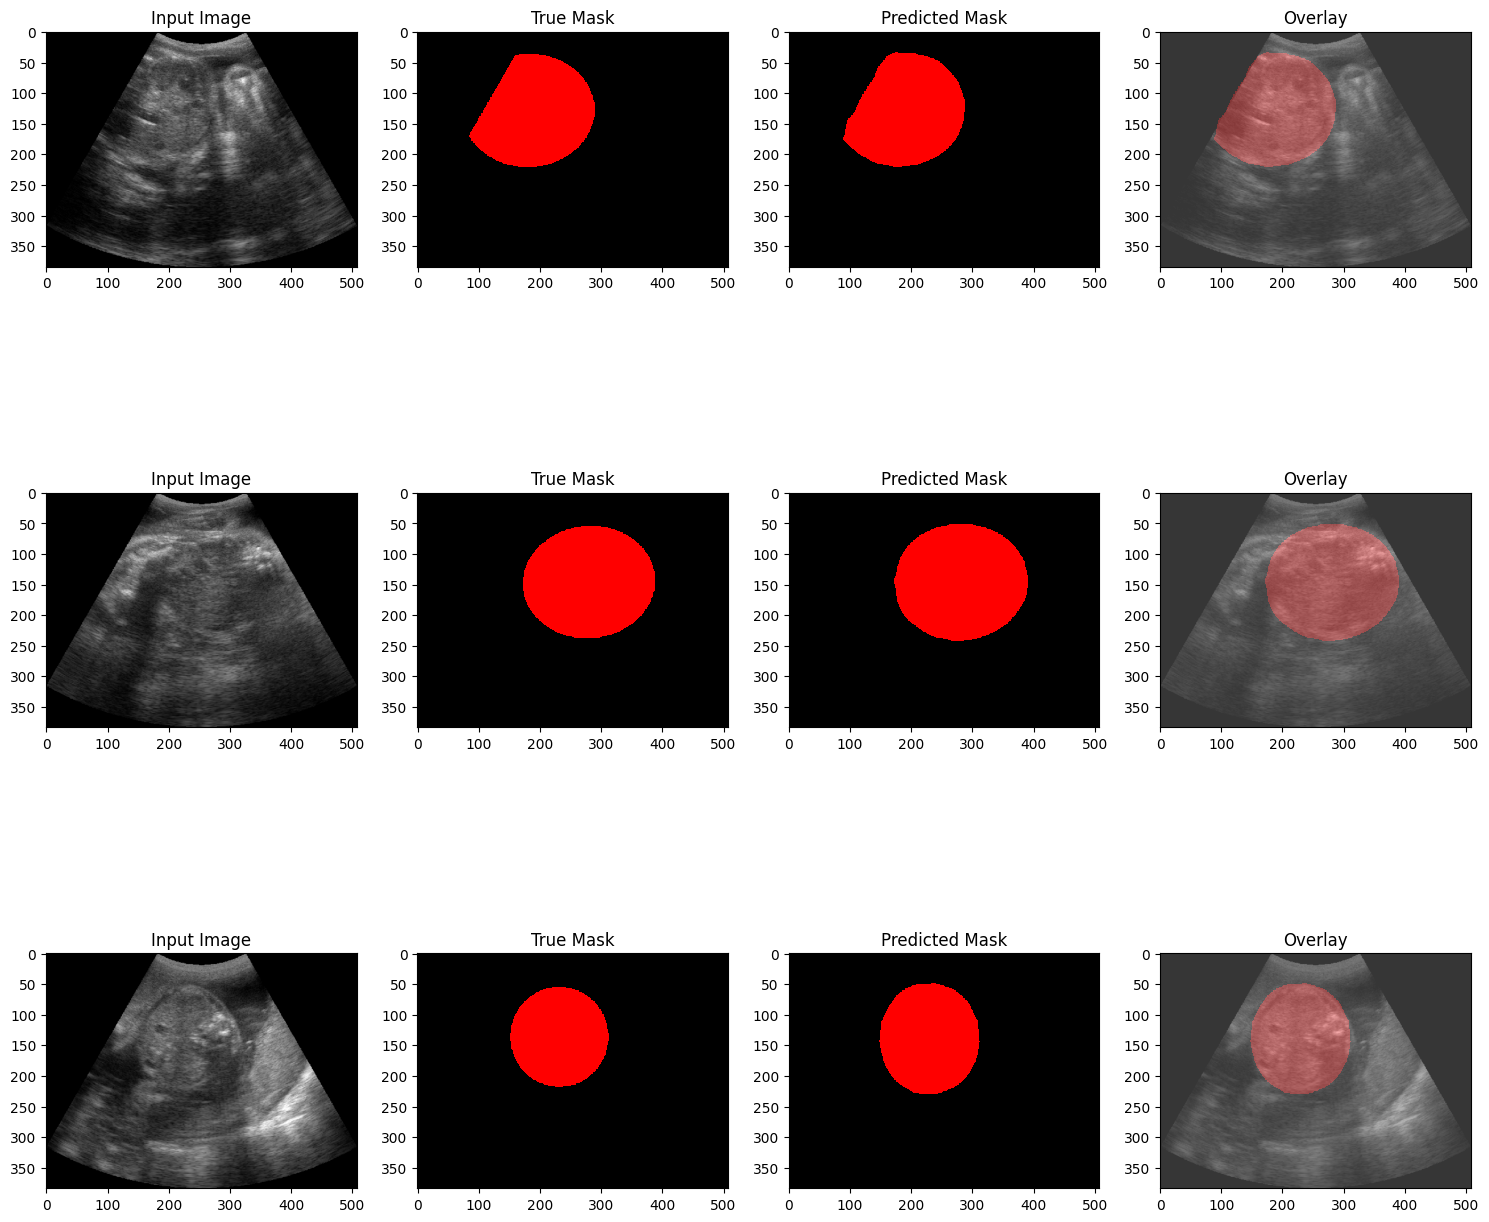

 Evaluation Metrics
Mean IoU   : 0.96025497
Accuracy   : 0.990207
Precision  : 0.9387968
Recall     : 0.9920832


In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall
import pickle

# with open("weights_tf10_compatible.pkl", "rb") as f:
#     weights = pickle.load(f)
# models.set_weights(weights)
model.load_weights('weights.h5')


miou_metric = MeanIoU(num_classes=2)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()


cmap = ListedColormap(['black', 'green', 'red'])

#  每轮展示多少图像
num = 3

#  从验证集取一个 batch
for image, mask in dataset_test.take(1):
    # 模型预测（logits -> 类别索引）
    logits = model.predict(image)
    pred_mask = tf.argmax(logits, axis=-1)           # (B, H, W)
    pred_mask = pred_mask[..., tf.newaxis]           # (B, H, W, 1) for broadcasting

    # 可视化结果
    fig = plt.figure(figsize=(15, num * 5))

    for i in range(num):
        if mask[i].shape[-1] > 1:
            true_mask = tf.argmax(mask[i], axis=-1)
        else:
            true_mask = tf.squeeze(mask[i])
        true_mask = tf.cast(true_mask, tf.int32)

        pred = tf.squeeze(pred_mask[i])
        pred = tf.cast(pred, tf.int32)

        miou_metric.update_state(true_mask, pred)
        accuracy_metric.update_state(true_mask, pred)
        precision_metric.update_state(true_mask, pred)
        recall_metric.update_state(true_mask, pred)

        plt.subplot(num, 4, i * 4 + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.title("Input Image")

        plt.subplot(num, 4, i * 4 + 2)
        plt.imshow(true_mask, cmap=cmap, interpolation='nearest')
        plt.title("True Mask")

        plt.subplot(num, 4, i * 4 + 3)
        plt.imshow(pred, cmap=cmap, interpolation='nearest')
        plt.title("Predicted Mask")

        plt.subplot(num, 4, i * 4 + 4)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]), alpha=0.7)
        plt.imshow(pred, cmap=cmap, alpha=0.3, interpolation='nearest')
        plt.title("Overlay")

    plt.tight_layout()
    plt.show()

print(" Evaluation Metrics")
print("Mean IoU   :", miou_metric.result().numpy())
print("Accuracy   :", accuracy_metric.result().numpy())
print("Precision  :", precision_metric.result().numpy())
print("Recall     :", recall_metric.result().numpy())


In [8]:
import tensorflow as tf
from matplotlib.colors import ListedColormap
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall

miou_metric = MeanIoU(num_classes=2)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()

cmap = ListedColormap(['black', 'green', 'red'])

for image, mask in dataset_test:
    logits = model.predict(image)
    pred_mask = tf.argmax(logits, axis=-1)           # (B, H, W)
    pred_mask = pred_mask[..., tf.newaxis]           # (B, H, W, 1)

    for i in range(image.shape[0]):
        if mask[i].shape[-1] > 1:
            true_mask = tf.argmax(mask[i], axis=-1)
        else:
            true_mask = tf.squeeze(mask[i])
        true_mask = tf.cast(true_mask, tf.int32)

        pred = tf.squeeze(pred_mask[i])
        pred = tf.cast(pred, tf.int32)

        miou_metric.update_state(true_mask, pred)
        accuracy_metric.update_state(true_mask, pred)
        precision_metric.update_state(true_mask, pred)
        recall_metric.update_state(true_mask, pred)

print("\n Evaluation Metrics on Test Set")
print("Mean IoU   :", round(miou_metric.result().numpy(), 4))
print("Accuracy   :", round(accuracy_metric.result().numpy(), 4))
print("Precision  :", round(precision_metric.result().numpy(), 4))
print("Recall     :", round(recall_metric.result().numpy(), 4))


1/1 [==============================] - 1s 939ms/step

 Evaluation Metrics on Test Set
Mean IoU   : 0.9595
Accuracy   : 0.9905
Precision  : 0.9325
Recall     : 0.9972


In [9]:
import tensorflow as tf
from matplotlib.colors import ListedColormap
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall
import numpy as np

with open("weights_tf10_compatible.pkl", "rb") as f:
    weights = pickle.load(f)
model.set_weights(weights)

miou_metric = MeanIoU(num_classes=2)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()

num_classes = 2
confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

cmap = ListedColormap(['black', 'green', 'red'])

for image, mask in dataset_test:
    logits = model.predict(image)
    pred_mask = tf.argmax(logits, axis=-1)           # (B, H, W)
    pred_mask = pred_mask[..., tf.newaxis]           # (B, H, W, 1)

    for i in range(image.shape[0]):
        if mask[i].shape[-1] > 1:
            true_mask = tf.argmax(mask[i], axis=-1)
        else:
            true_mask = tf.squeeze(mask[i])
        true_mask = tf.cast(true_mask, tf.int32)

        pred = tf.squeeze(pred_mask[i])
        pred = tf.cast(pred, tf.int32)

        miou_metric.update_state(true_mask, pred)
        accuracy_metric.update_state(true_mask, pred)
        precision_metric.update_state(true_mask, pred)
        recall_metric.update_state(true_mask, pred)

        y_true = tf.reshape(true_mask, [-1])
        y_pred = tf.reshape(pred, [-1])
        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes).numpy()
        confusion_matrix += cm

dice_per_class = []
for i in range(num_classes):
    TP = confusion_matrix[i, i]
    FP = np.sum(confusion_matrix[:, i]) - TP
    FN = np.sum(confusion_matrix[i, :]) - TP
    denom = 2 * TP + FP + FN
    dice = 2 * TP / denom if denom > 0 else 0.0
    dice_per_class.append(dice)

mean_dice = np.mean(dice_per_class)

print("\n Evaluation Metrics on Test Set")
print("Mean IoU   :", round(miou_metric.result().numpy(), 4))
print("Accuracy   :", round(accuracy_metric.result().numpy(), 4))
print("Precision  :", round(precision_metric.result().numpy(), 4))
print("Recall     :", round(recall_metric.result().numpy(), 4))
print("Dice Coef. :", [f"Class {i}: {round(d, 4)}" for i, d in enumerate(dice_per_class)])
print("Mean Dice  :", round(mean_dice, 4))

1/1 [==============================] - 0s 39ms/step

 Evaluation Metrics on Test Set
Mean IoU   : 0.9662
Accuracy   : 0.9922
Precision  : 0.9505
Recall     : 0.9898
Dice Coef. : ['Class 0: 0.9955', 'Class 1: 0.9698']
Mean Dice  : 0.9826
